# Analyses of trial clusters

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [33]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# Get my functions
functions_path = prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import revert_to_original, get_ballistic, get_no_resp
functions_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import transition_probabilities
from plotting_functions import plot_binned_sequence
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Get data

In [26]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [27]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

In [28]:
use_key = 'feedback' # session trial_typefilter
use_order = ['correct', 'incorrect']
# use_order = ['0.0', '0.0625', '0.125', '0.25', '1.0']
# use_order = ['0.5', '0.2', '0.8']
unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = trial_clusters[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
trial_clusters['numeric_trial_code'] = trial_clusters[use_key].map(map_to_use)

## Plot

### Plot trial cluster info

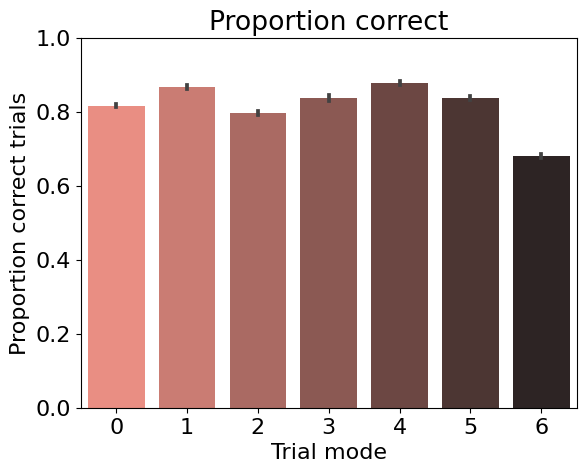

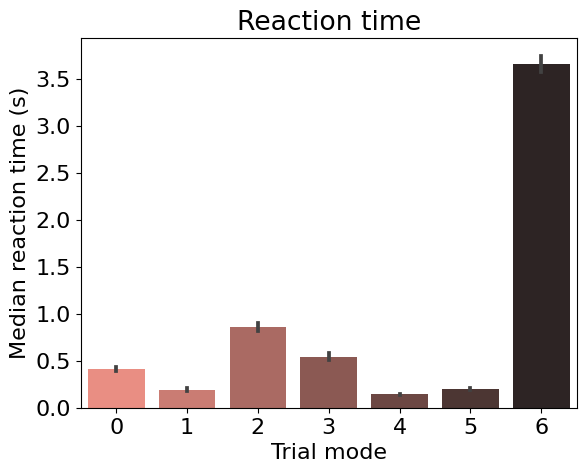

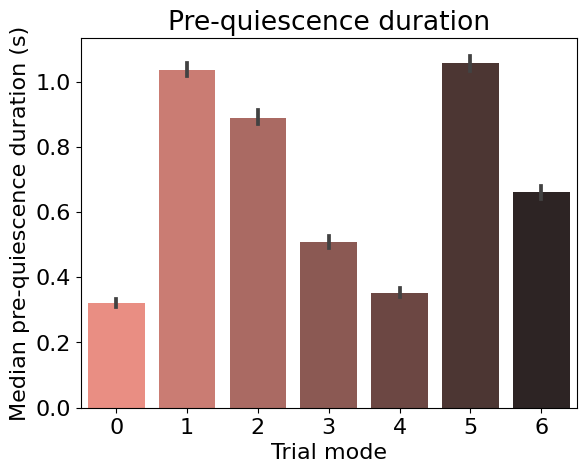

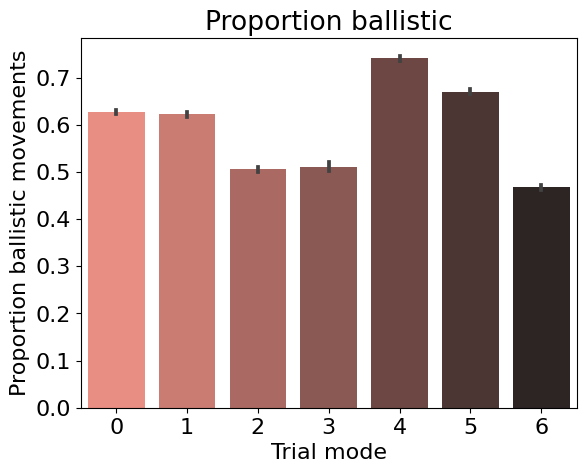

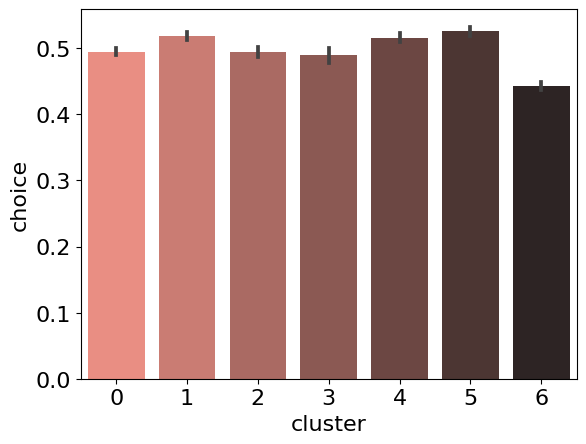

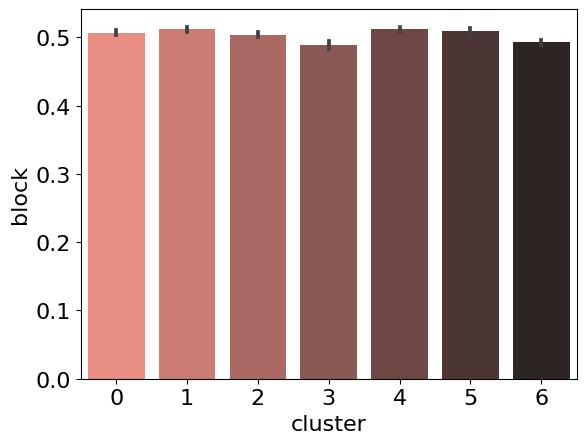

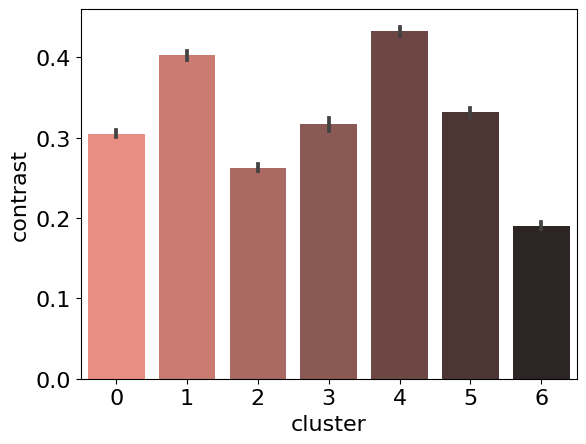

In [5]:
save_path = prefix + 'representation_learning_variability/Exported figures/COSYNE/'
plt.rcParams.update({'font.size': 16})

palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
sns.barplot(x='cluster', y='feedback', data=trial_clusters, palette=palette)
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
plt.ylim([0,1])
plt.xlabel('Trial mode')
plt.savefig(save_path+'trial_cluster_feedback.svg', format="svg")
plt.show()

sns.barplot(x='cluster', y='reaction', data=trial_clusters, palette=palette)
plt.ylabel('Median reaction time (s)')
plt.title('Reaction time')
plt.xlabel('Trial mode')
plt.savefig(save_path+'trial_cluster_reaction.svg', format="svg")
plt.show()

sns.barplot(x='cluster', y='elongation', data=trial_clusters, palette=palette)
plt.ylabel('Median pre-quiescence duration (s)')
plt.title('Pre-quiescence duration')
plt.xlabel('Trial mode')
plt.savefig(save_path+'trial_cluster_elongation.svg', format="svg")
plt.show()

sns.barplot(x='cluster', y='ballistic', data=trial_clusters, palette=palette)
plt.ylabel('Proportion ballistic movements')
plt.title('Proportion ballistic')
plt.xlabel('Trial mode')
plt.savefig(save_path+'trial_cluster_ballistic.svg', format="svg")
plt.show()

sns.barplot(x='cluster', y='choice', data=trial_clusters, palette=palette)
plt.savefig(save_path+'trial_cluster_choice.svg', format="svg")
plt.show()
sns.barplot(x='cluster', y='block', data=trial_clusters, palette=palette)
plt.savefig(save_path+'trial_cluster_block.svg', format="svg")
plt.show()
sns.barplot(x='cluster', y='contrast', data=trial_clusters, palette=palette)
plt.savefig(save_path+'trial_cluster_contrast.svg', format="svg")
plt.show()

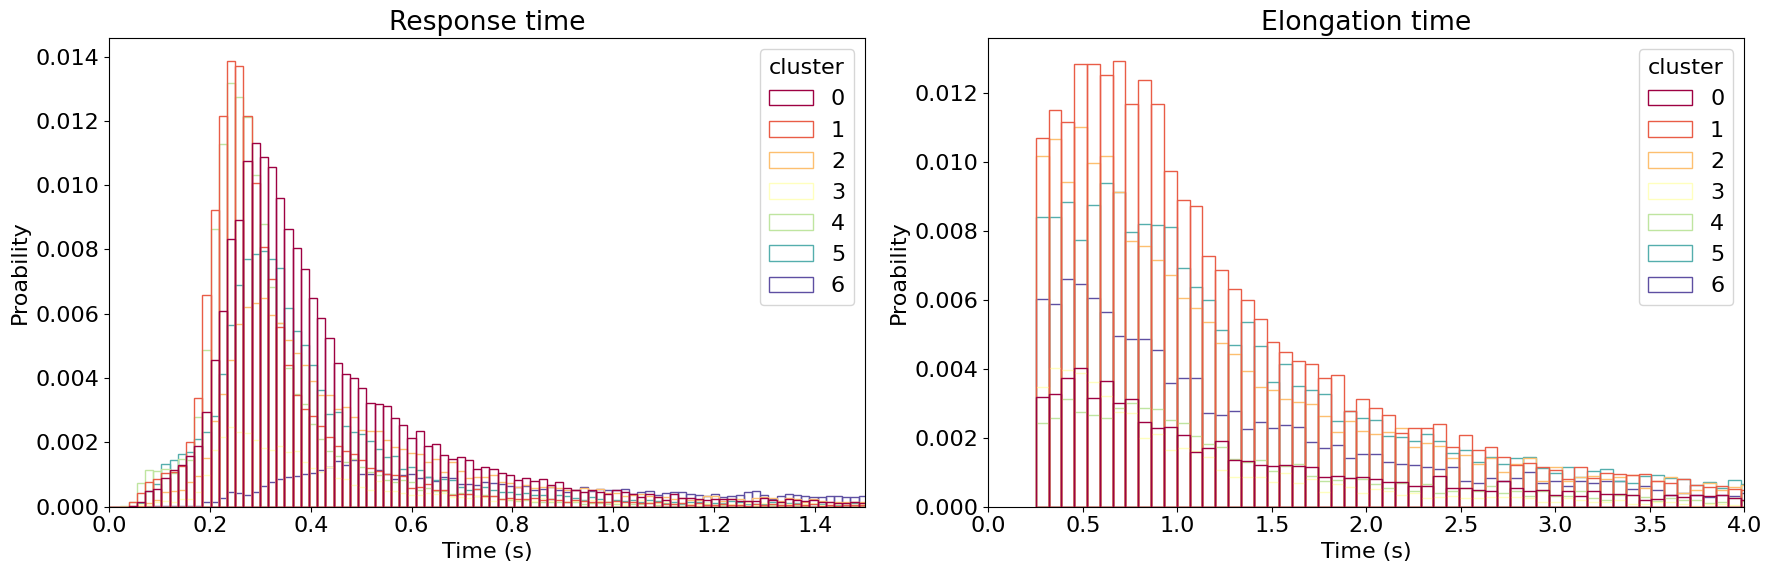

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 6))

sns.histplot(data=trial_clusters, x='response', stat='probability', ax=axs[0], hue='cluster', fill=False, palette="Spectral",
   alpha=1, linewidth=1)
sns.histplot(data=trial_clusters.loc[trial_clusters['elongation']>0.25], x='elongation', stat='probability', ax=axs[1], hue='cluster', fill=False,  palette="Spectral",
   alpha=1, linewidth=1)

axs[0].set_xlim(0, 1.5)
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Response time')
axs[0].set_ylabel('Proability')
axs[1].set_xlim(0, 4)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Elongation time')
axs[1].set_ylabel('Proability')
plt.tight_layout()
plt.show()

## Plot states

In [6]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
y_kmeans_trials = trial_clusters['cluster']

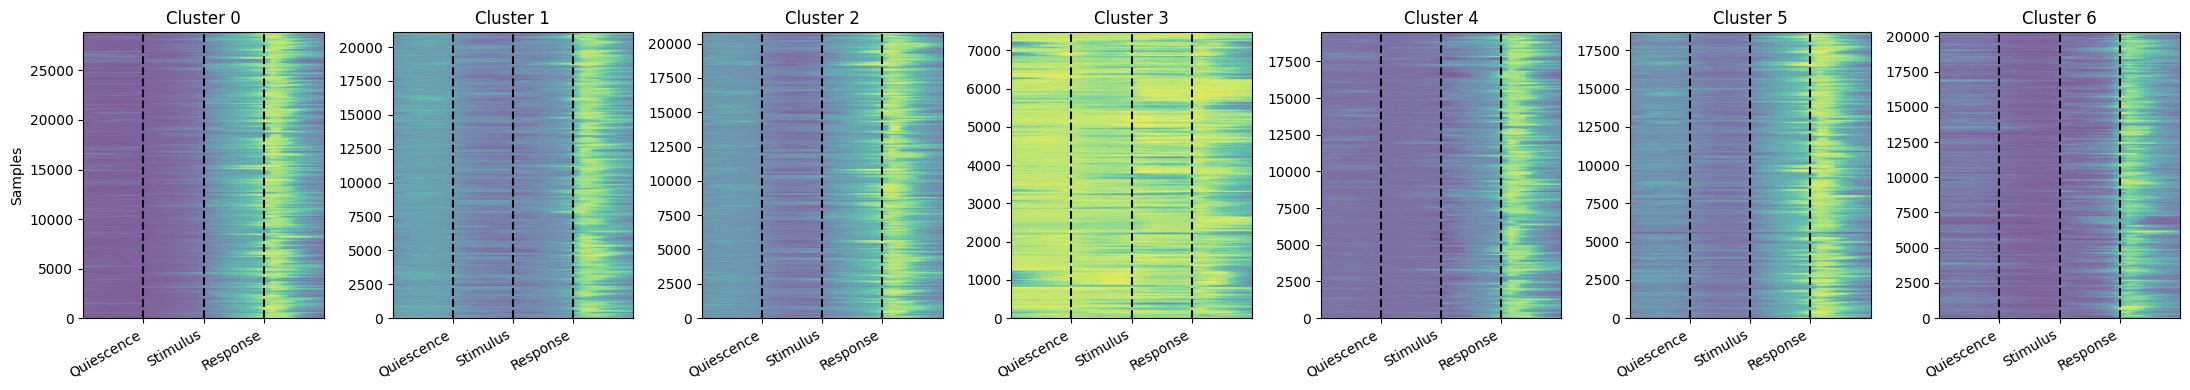

In [7]:
states_to_append = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 10, 11, 12, 13, 14, 15, 0, 0, 0]])
states_to_append = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0,
                              0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 0, 0, 0]])

fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=False, figsize=(22, 4))


for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
#     plt.figure(figsize=(6, 2))
    axs[c].imshow(np.concatenate([use_sequences, states_to_append]), 
    extent=(0, np.shape(np.concatenate([use_sequences, states_to_append]))[1], 
            0, np.shape(np.concatenate([use_sequences, states_to_append]))[0]),
    aspect="auto",
    cmap='viridis',
    alpha=0.7) 


    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')

    # axs[c].set_xlabel('Time in epoch')
    axs[c].set_title('Cluster ' + str(c))
axs[0].set_ylabel('Samples')
plt.tight_layout()
plt.show()

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Load color palette
colors = sns.color_palette("Set2", 7)

# Function to create a colormap from a base color (white to color)
def create_shaded_cmap(base_color, name='custom_cmap'):
    cdict = {
        'red':   [[0.0, 1.0, 1.0], [1.0, base_color[0], base_color[0]]],
        'green': [[0.0, 1.0, 1.0], [1.0, base_color[1], base_color[1]]],
        'blue':  [[0.0, 1.0, 1.0], [1.0, base_color[2], base_color[2]]]
    }
    return LinearSegmentedColormap(name, cdict)



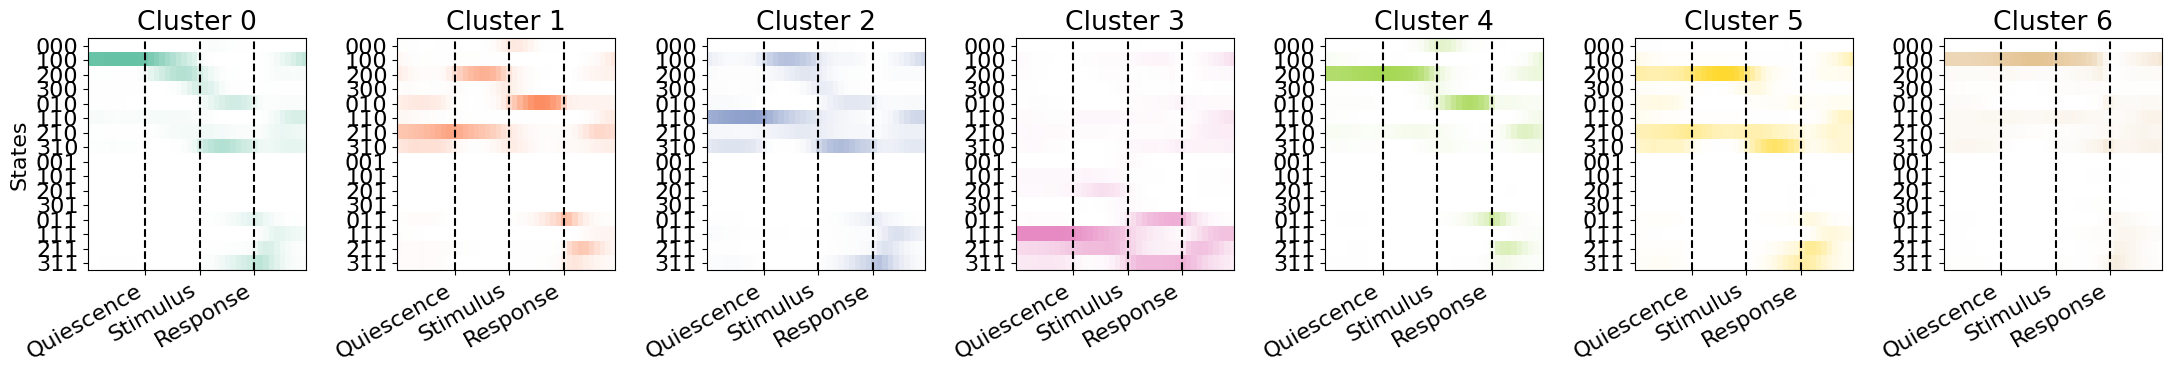

In [14]:
# color = sns.color_palette("Set2", 10)
fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=False, figsize=(22, 4))

for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    cluster_count = np.zeros((16, 40))
#     plt.figure(figsize=(6, 2))
    for b, bin in enumerate(range(40)):
        counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        cluster_count[:, b] = counts
        # plt.plot(bins[:-1], counts, color=color[b])
#         plt.stairs(counts, bins, color=color[b], alpha=1)
#         plt.xticks(np.arange(0, 16, 1), np.arange(0, 16, 1))
#         plt.title(cluster)
#     plt.show()
    cmap_value_1 = create_shaded_cmap(colors[c], name='cmap_value_1')
    axs[c].imshow(cluster_count, cmap=cmap_value_1, aspect='auto')
    axs[c].set_yticks(np.arange(0, 16, 1), ['000', '100', '200','300', '010', '110','210','310','001','101',
           '201', '301', '011', '111','211','311'
           ])
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[c].set_title('Cluster ' +str(cluster))
axs[0].set_ylabel('States')
plt.tight_layout()
plt.show()


# Plot separate behaviors

In [9]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)

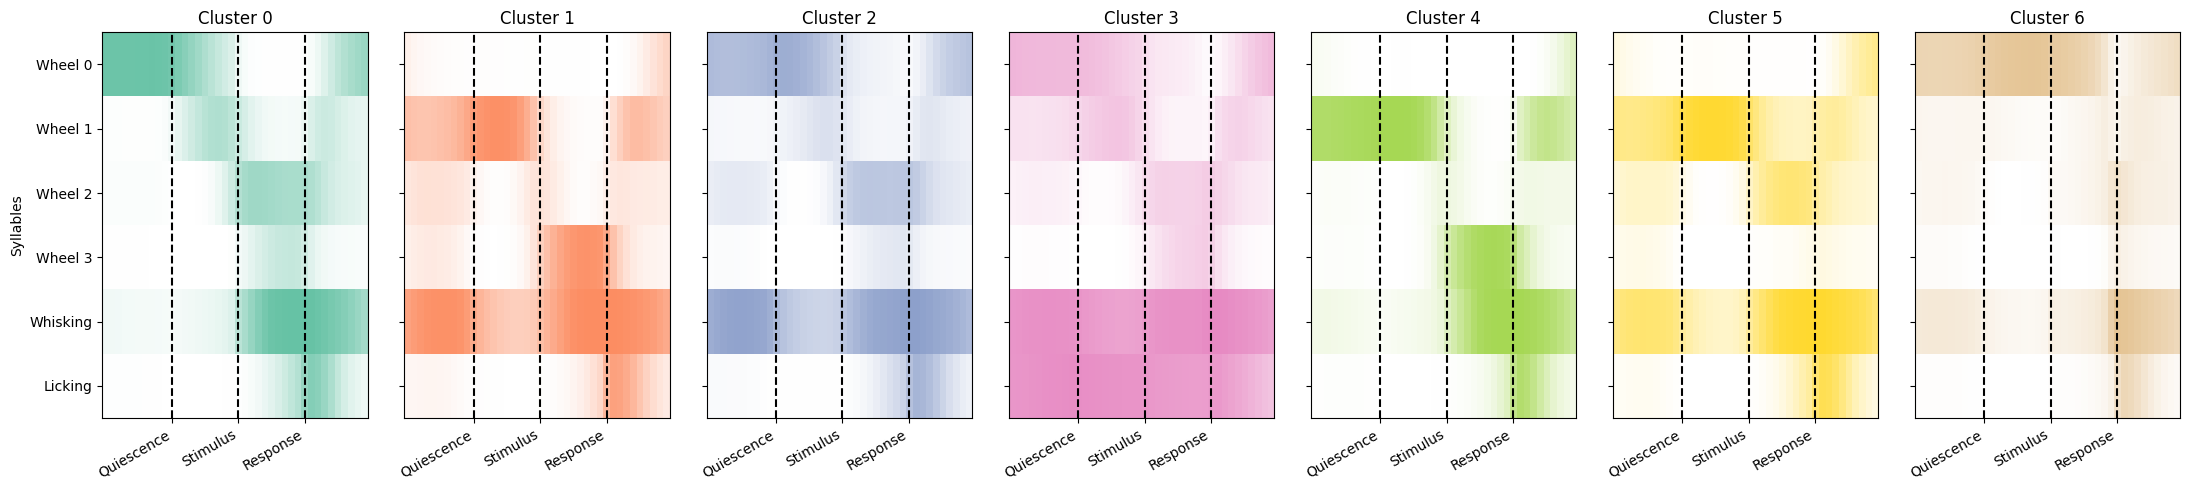

In [8]:
color = sns.color_palette("Set2", 10)
fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=True, figsize=(22, 5))

for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)
        lick_count[0, b] = np.sum(lick_states[:, b]==1)
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    
    cmap_value_1 = create_shaded_cmap(colors[c], name='cmap_value_1')
    # axs[c].imshow(whisker_count, cmap=cmap_value_1, aspect='auto')
    axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[c].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[c].set_title('Cluster ' +str(cluster))
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

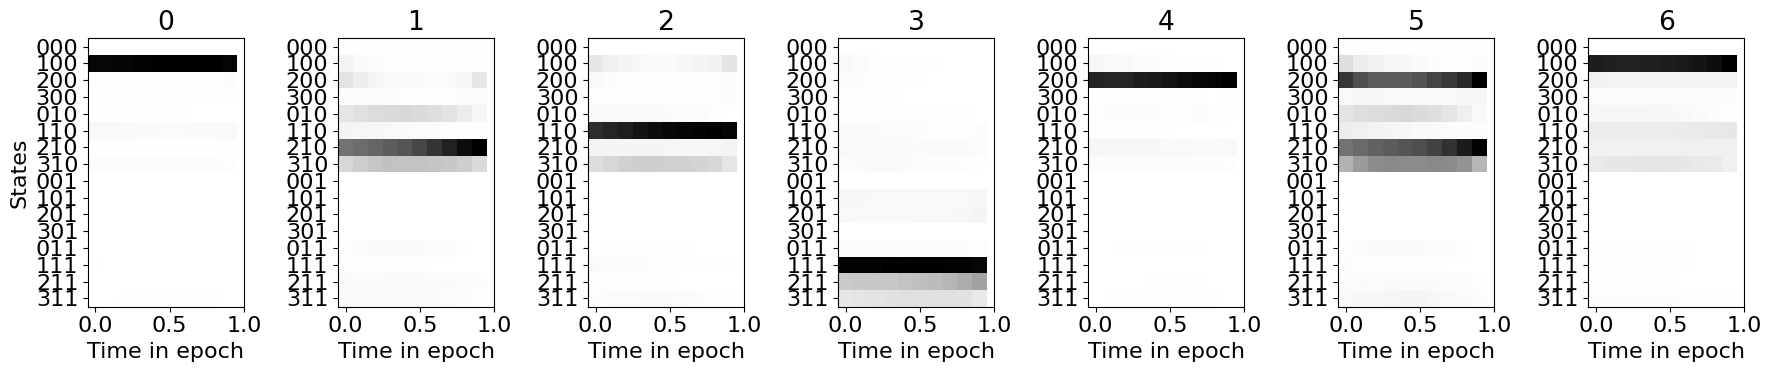

In [17]:
color = sns.color_palette("Spectral", 10)
fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=False, figsize=(18, 4))

for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    cluster_count = np.zeros((16, 10))
#     plt.figure(figsize=(6, 2))
    for b, bin in enumerate(range(10)):
        counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        cluster_count[:, b] = counts
        # plt.plot(bins[:-1], counts, color=color[b])
#         plt.stairs(counts, bins, color=color[b], alpha=1)
#         plt.xticks(np.arange(0, 16, 1), np.arange(0, 16, 1))
#         plt.title(cluster)
#     plt.show()
    axs[c].imshow(cluster_count, cmap='Greys', aspect='auto')
    axs[c].set_yticks(np.arange(0, 16, 1), ['000', '100', '200','300', '010', '110','210','310','001','101',
           '201', '301', '011', '111','211','311'
           ])
    axs[c].set_xticks(np.arange(0, 11, 5), np.arange(0, 1.1, .5))
    axs[c].set_xlabel('Time in epoch')
    axs[c].set_title(cluster)
axs[0].set_ylabel('States')
plt.tight_layout()
plt.show()


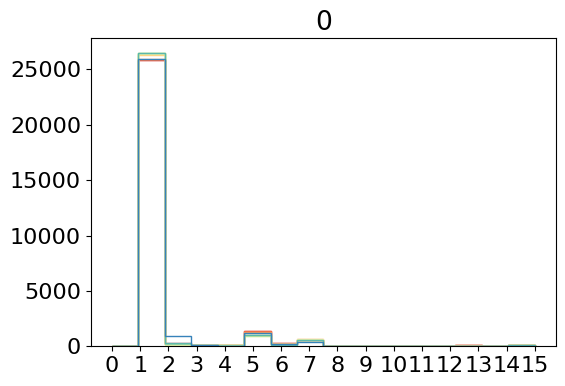

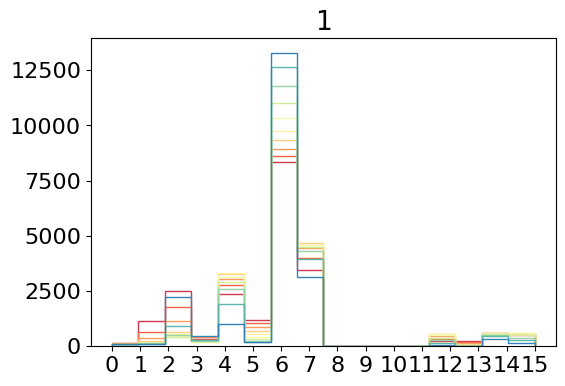

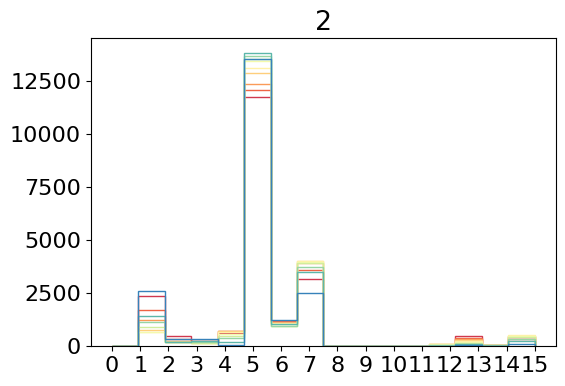

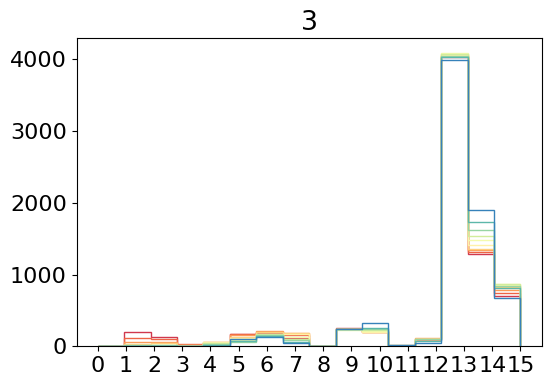

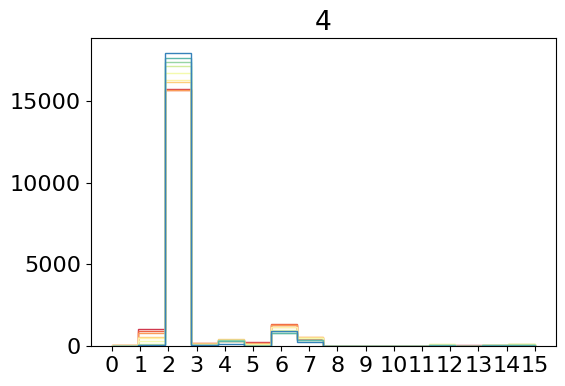

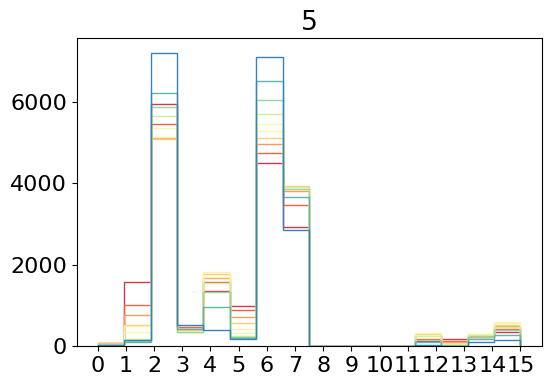

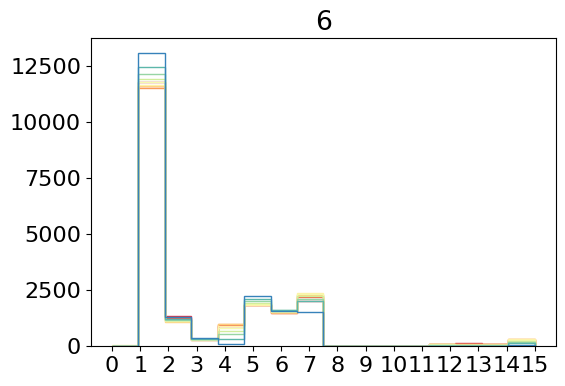

In [18]:
color = sns.color_palette("Spectral", 10)
# fig, axs = plt.subplots(1, len(np.unique(y_kmeans_trials)), sharex=True, sharey=False, figsize=(18, 4))

for c, cluster in enumerate(np.unique(y_kmeans_trials)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    cluster_count = np.zeros((16, 10))
    plt.figure(figsize=(6, 4))
    for b, bin in enumerate(range(10)):
        counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        cluster_count[:, b] = counts
        # plt.plot(bins[:-1], counts, color=color[b])
        plt.stairs(counts, bins, color=color[b], alpha=1)
        plt.xticks(np.arange(0, 16, 1), np.arange(0, 16, 1))
        plt.title(cluster)
    plt.show()
#     axs[c].imshow(cluster_count, cmap='Greys', aspect='auto')
#     axs[c].set_yticks(np.arange(0, 16, 1), ['000', '100', '200','300', '010', '110','210','310','001','101',
#            '201', '301', '011', '111','211','311'
#            ])
#     axs[c].set_xticks(np.arange(0, 11, 5), np.arange(0, 1.1, .5))
#     axs[c].set_xlabel('Time in epoch')
#     axs[c].set_title(cluster)
# axs[0].set_ylabel('States')
# plt.tight_layout()
# plt.show()


# Plot state probability

NameError: name 'file_path' is not defined

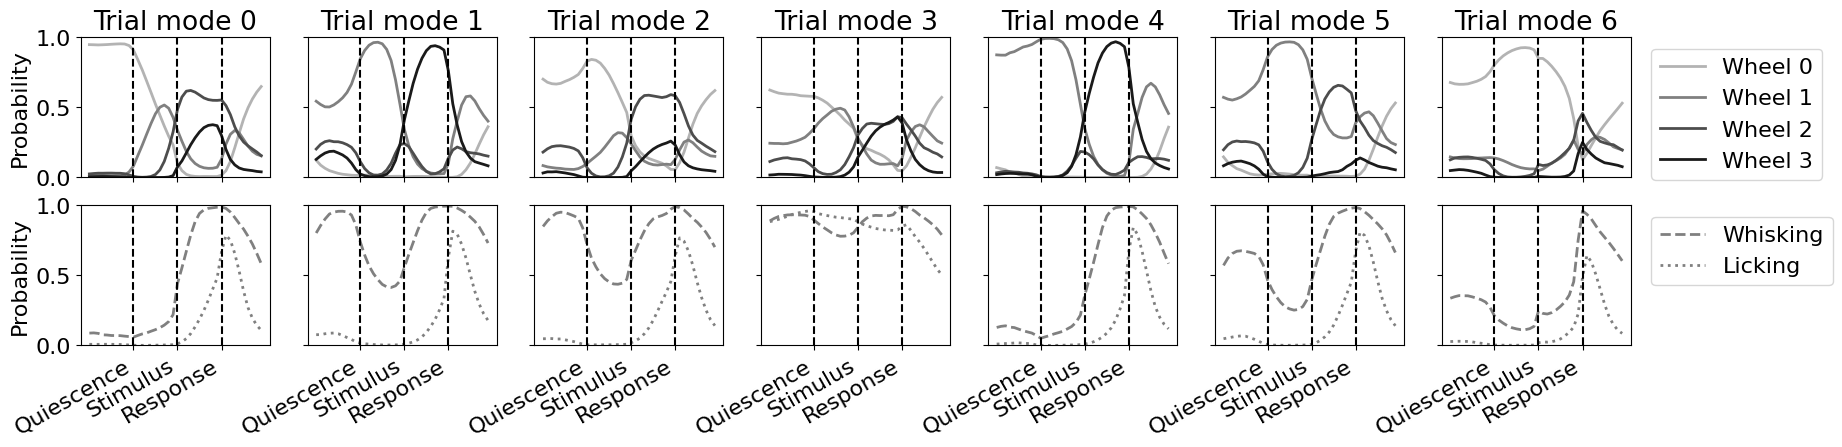

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
trial_cluster_num = len(trial_clusters['cluster'].unique())

fig, axs = plt.subplots(2, trial_cluster_num, sharex=True, sharey=True, figsize=(20, 4))

for c, cluster in enumerate(range(trial_cluster_num)):
    cluster_data = trial_clusters.loc[trial_clusters['cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])

    num_lines = 4
    colors = [str(1- 0.6 * (i / (num_lines - 1))-.3) for i in range(num_lines)]  # Light to dark gray
    axs[0, c].set_prop_cycle(color=colors)
    axs[0, c].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'], linewidth=2)
    axs[1, c].plot(all_stacked[4:5, :].T, label='Whisking', color='grey', linewidth=2, linestyle='--')
    axs[1, c].plot(all_stacked[5:6, :].T, label='Licking', color='grey', linewidth=2, linestyle=':')

    axs[0, c].axvline(x=10, color='k', linestyle='--')
    axs[0, c].axvline(x=20, color='k', linestyle='--')
    axs[0, c].axvline(x=30, color='k', linestyle='--')
    axs[1, c].axvline(x=10, color='k', linestyle='--')
    axs[1, c].axvline(x=20, color='k', linestyle='--')
    axs[1, c].axvline(x=30, color='k', linestyle='--')
    # axs[2, c].axvline(x=10, color='k', linestyle='--')
    # axs[2, c].axvline(x=20, color='k', linestyle='--')
    # axs[2, c].axvline(x=30, color='k', linestyle='--')
    axs[0, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[1, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[2, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[0, c].set_title('Trial mode ' +str(cluster))
    axs[0, c].set_ylim([0, 1])
    axs[1, c].set_ylim([0, 1])
    # axs[2, c].set_ylim([0, 1])

axs[0, 0].set_ylabel('Probability')
axs[1, 0].set_ylabel('Probability')
# axs[2, 0].set_ylabel('Probability')

axs[0, 6].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[1, 6].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axs[2, 6].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.tight_layout()
# fig.savefig(file_path+'trial_mode_states.svg', format="svg")


## Plot ballistic stats per cluster

In [9]:
use_data = trial_clusters.copy()
use_data = get_no_resp(use_data)
use_data.loc[use_data['resp']=='response', 'resp'] = 1
use_data.loc[use_data['resp']=='non_response', 'resp'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['resp'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='resp', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']) # hue_order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
plt.xlabel('Cluster')
plt.ylabel('Proportion of response-plausible movements')
plt.show()

KeyError: 'identifiable_states'

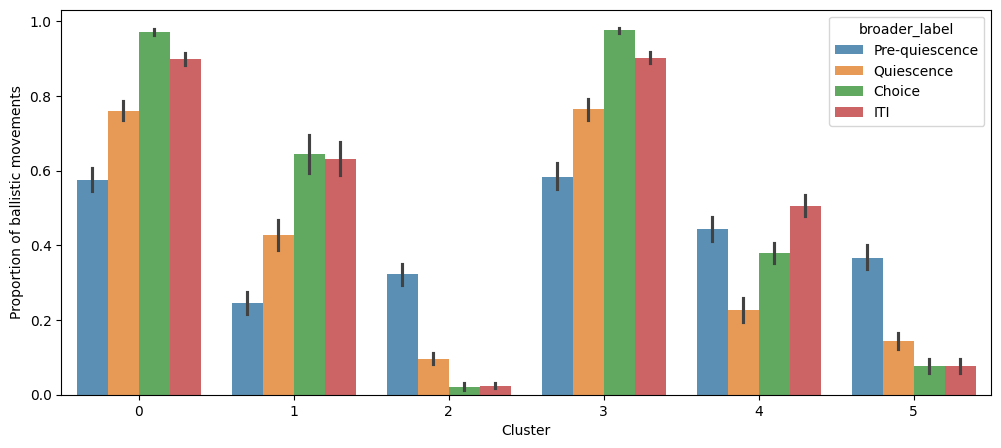

In [25]:
use_data = trial_clusters.copy()
use_data = get_ballistic(use_data)
use_data.loc[use_data['bal_state']=='balistic', 'bal_state'] = 1
use_data.loc[use_data['bal_state']=='non_balistic', 'bal_state'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['bal_state'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='bal_state', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'])
plt.xlabel('Cluster')
plt.ylabel('Proportion of ballistic movements')
plt.show()